# FNN MFCC - With Patient

Author: Jake Dumbauld <br>
Contact: jacobmilodumbauld@gmail.com<br>
Date: 3.15.22

In [1]:
#imports

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import time
import re

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import regularizers
import keras_tuner as kt

In [2]:
import random as python_random

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
python_random.seed(42)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(42)

#not sure if the below are necessary - leaving in to perhaps un-comment later.
%env PYTHONHASHSEED=0
%env CUDA_VISIBLE_DEVICES=""

env: PYTHONHASHSEED=0
env: CUDA_VISIBLE_DEVICES=""


## Helper Functions

### Model Loss

In [3]:
def graph_model_loss(title, history):
    """
    Description:
    Graphs training vs validation loss over epochs for a given model. 
    
    History: tensorflow.python.keras.callbacks.History object
    Title: str
    """ 
    plt.figure(figsize=(12,8))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title,size=24)
    plt.ylabel('Loss',size=16)
    plt.xlabel('Epoch',size=16)
    plt.legend(['Train', 'Validation'])
    plt.show()

### Train/Test Acc Printout

In [4]:
def evaluate_model(model, history):
    """
    Description:
    Outputs model train & test accuracies for currently defined train and test set variables.
    
    model: tensorflow model,
    history: tensorflow.python.keras.callbacks.History object
    """
    # Evaluate the network
    train_accuracy = history.history["binary_accuracy"][-1]
    result = model.evaluate(X_test,y_test, verbose=1)

    print(f"Train Accuracy: {np.round(train_accuracy, 6)*100}%")
    print(f"Test Accuracy: {np.round(result[1], 6)*100}%")

### Defining Hyperparameter Search Space

In [5]:
def build_model(hp):
    model = keras.Sequential()
    #flattening input
    model.add(Flatten())
    
    for i in range(hp.Int('layers', 2, 4)):
        model.add(
            Dense(
            #Tuning the number of units in my input layer.
            units=hp.Int("units" + str(i), min_value=32, max_value=1024, step=64),
            kernel_regularizer=regularizers.l2(0.001),
            activation="relu"
            )
        )
        #Tuning whether or not to use dropout.
        if hp.Boolean("dropout" + str(i)):
            model.add(Dropout(rate=0.25))

        #Adding batch normalization
        if hp.Boolean("normalization" + str(i)):
            model.add(BatchNormalization())

    #output layer
    model.add(Dense(1, activation="sigmoid"))
    
    #defining learning rate
    lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
                      #tuning initial learning rate
                      initial_learning_rate=hp.Float("starting_learning_rate", min_value=1e-4, max_value=1e-2, sampling="log"),
                      decay_steps=1.0,
                      decay_rate=0.1
                  )
    model.compile(
        #Optimizer
        optimizer = keras.optimizers.Adam(learning_rate=lr_schedule),
        #Loss
        loss=keras.losses.BinaryCrossentropy(),
        #Metrics
        metrics=[keras.metrics.BinaryAccuracy()]
    )
    return model

build_model(kt.HyperParameters())

2022-04-01 11:51:27.416605: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
X = np.load('/Users/jmd/Documents/BOOTCAMP/Capstone/arrays/MFCCs_withPatient.npy', allow_pickle=True)
y = np.load('/Users/jmd/Documents/BOOTCAMP/Capstone/arrays/target_array.npy', allow_pickle=True)

#train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.3)

In [9]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [10]:
tuner = kt.BayesianOptimization(
    hypermodel=build_model,
    objective="val_loss",
    max_trials=50,
    seed=42,
    overwrite=True,
    directory='/Users/jmd/Documents/BOOTCAMP/Capstone/kerastune_searches',
    project_name='sequential_MFCC_with_patient'
)

tuner.search(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[es_callback])

Trial 50 Complete [00h 00m 00s]
val_loss: 0.5607123374938965

Best val_loss So Far: 0.5161057710647583
Total elapsed time: 00h 07m 29s
INFO:tensorflow:Oracle triggered exit


In [11]:
tuner.results_summary(num_trials=1)

Results summary
Results in /Users/jmd/Documents/BOOTCAMP/Capstone/kerastune_searches/sequential_MFCC_with_patient
Showing 1 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
layers: 2
units0: 32
dropout0: True
normalization0: True
units1: 288
dropout1: True
normalization1: False
starting_learning_rate: 0.01
units2: 288
dropout2: False
normalization2: False
units3: 32
dropout3: True
normalization3: True
Score: 0.5161057710647583


In [12]:
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [13]:
# Get the best hyperparameters.
best_hps = tuner.get_best_hyperparameters()
# Build the model with the best hp.
model = build_model(best_hps[0])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val,y_val), callbacks=[es_callback])

Epoch 1/100
46/46 [==============================] - 0s 4ms/step - loss: 0.6529 - binary_accuracy: 0.7674 - val_loss: 0.9494 - val_binary_accuracy: 0.7959
Epoch 2/100
46/46 [==============================] - 0s 2ms/step - loss: 0.5513 - binary_accuracy: 0.8045 - val_loss: 0.5358 - val_binary_accuracy: 0.8006
Epoch 3/100
46/46 [==============================] - 0s 2ms/step - loss: 0.5194 - binary_accuracy: 0.8032 - val_loss: 0.6022 - val_binary_accuracy: 0.7911
Epoch 4/100
46/46 [==============================] - 0s 2ms/step - loss: 0.5095 - binary_accuracy: 0.8044 - val_loss: 0.7357 - val_binary_accuracy: 0.5158
Epoch 5/100
46/46 [==============================] - 0s 2ms/step - loss: 0.5024 - binary_accuracy: 0.8115 - val_loss: 0.6223 - val_binary_accuracy: 0.7009
Epoch 6/100
46/46 [==============================] - 0s 2ms/step - loss: 0.5014 - binary_accuracy: 0.8058 - val_loss: 0.5726 - val_binary_accuracy: 0.7563
Epoch 7/100
46/46 [==============================] - 0s 2ms/step - los

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 2910)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                93152     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 288)               9504      
_________________________________________________________________
dropout_3 (Dropout)          (None, 288)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [15]:
evaluate_model(model, history)

29/29 [==============================] - 0s 554us/step - loss: 0.6225 - binary_accuracy: 0.6932
Train Accuracy: 83.0842%
Test Accuracy: 69.3245%


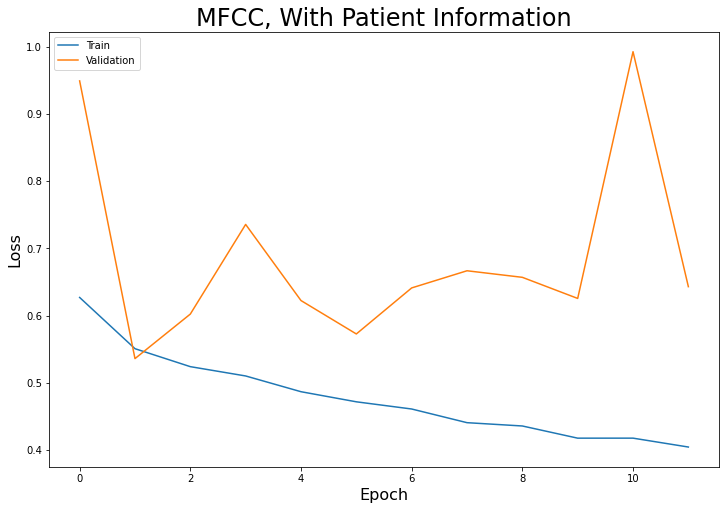

In [16]:
graph_model_loss('MFCC, With Patient Information', history)

In [18]:
#saving model
model.save('/Users/jmd/Documents/BOOTCAMP/Capstone/neural_nets/sequential_MFCCs_with_patient', overwrite=True)

INFO:tensorflow:Assets written to: /Users/jmd/Documents/BOOTCAMP/Capstone/neural_nets/sequential_MFCCs_with_patient/assets
